<a href="https://colab.research.google.com/github/codelspak/Struggles/blob/main/WK27_case2_Kaggle_ML_Classification_Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 문제 : 사기/정상 거래를 구분하기 위한 모델을 수립
```
Label name : Class - 1(사기) or 0(정상 사용자)
```
보안 상의 문제로 데이터는 scaled 되어있음. 또한 feature name이 정보를 유추할 
수 없게 코드화되어있음. <br>
이 프로젝트는 다섯 가지 목표를 가지고 있음.<br>
```
1. 주어진 데이터셋 분포를 확인
2. NearMiss Algorithm을 이용해, 사기/정상 거래 비율이 50:50인 sub-dataframe 생성
3. 높은 정확도를 갖는 Classifier 결정
4. Neural Network 활용 - best classifier와 성능(정확도) 비교
5. 불균등 데이터셋(Imbalanced data)에서 저지를 수 있는 실수에 대해 이해
```

단, 3/4번 목표와 관련하여, 본 문제는 Class간에 분포가 편향된 imbalanced data 문제로, 성능 지표로 정확도를 활용하는 것은 의미가 떨어지므로 Area Under the Precision-Recall Curve (AUPRC)를 활용하기로 함. <BR>
[Kaggle 노트북 출처](https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/notebook)

[Credit Card Fraud Detection - 문제 상황 이해](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html)

# 1. 필요한 라이브러리 및 데이터 불러오기 

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Other libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings 
warnings.filterwarnings('ignore')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/2. Kaggle Struggle/WK27_뉴욕택시가격예측_신용카드사기적발/creditcard.csv/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 2. 데이터 전처리(Preprocessing)
1. Scaling and distributing
2. Splitting

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df.isnull().sum().sum()

0

In [7]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

위 기초정보 확인을 통해 다음 세 가지를 확인함<bR>
1. 거래 비용이 상대적으로 낮음 - 평균 거래 비용 = $88
2. 결측치 없음 
3. 정상거래(99.83%) 대비 사기거래(0.17%) 비율 매우 낮음 

특히 3번에 대해, 별다른 조치 없이 skewed/imbalanced data를 그대로 이용해 사기/정상 거래 여부를 예측해준다면, 우리 알고리즘은 **대부분의 거래를 정상거래로 간주**한 상태에서 작동할 것.<br>
따라서 overfitting을 방지하고, 모델이 사기/정상거래 Class를 구분할 신호를 감지할 수 있도록 전처리와 Resampling을 진행해줄 것임

Text(0.5, 1.0, 'Class Distribution \n (0: No Fraud || 1 : Fraud)')

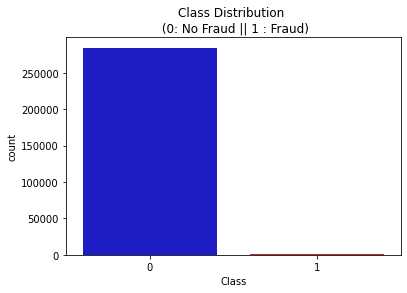

In [8]:
colors = ["#0101DF", "#DF0101"]
_ = sns.countplot(data = df, x = 'Class', palette = colors)
plt.title('Class Distribution \n (0: No Fraud || 1 : Fraud)')

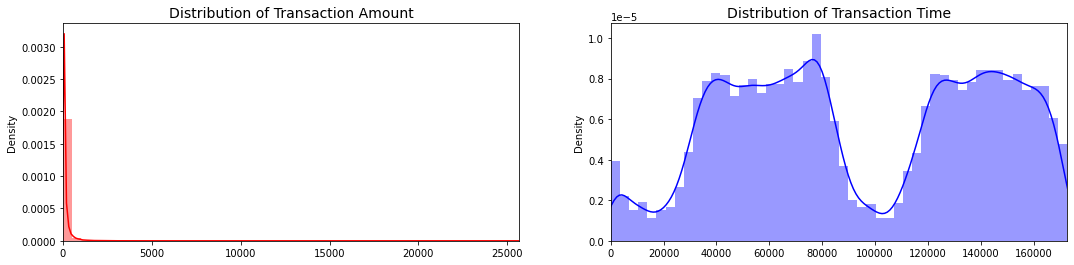

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax = ax[0], color = 'r')
ax[0].set_title('Distribution of Transaction Amount', fontsize =14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax = ax[1], color = 'b')
ax[1].set_title('Distribution of Transaction Time', fontsize =14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

위의 기술통계 dataframe을 보면, V1~V28 다른 컬럼들은 평균값이 e-16 수준으로 매우 작게 scale되어 있음을 알 수 있음.<br>
따라서 Time / Amount 컬럼 역시 여타 컬럼과 비슷하게 scale, distribute를 해줘야함을 알 수 있다.

Sub-sample (사기거래 vs 정상거래 비율이 50:50으로 동등하게 구성된) 생성 필요<br>
만약 심하게 치우친 원본 데이터를 그대로 사용할 경우, 아래와 같은 문제를 직면할 수 있음<br>
1. Overfitting - 대부분의 케이스가 정상 거래라고 가정하고 예측할 수 있음<br>
2. 왜곡된 상관관계 - 보안 문제로 V features가 의미하는 정확한 내용은 모르지만, feature - label variable 간 상관관계를 확인하는 건 예측이 도움이 될 수 있음<br> 이 때 편향된 데이터를 분석하면 정확한 상관관계의 본질을 못 볼 수 있음

## 2.1. Scaling and distributing

In [24]:
from sklearn.preprocessing import RobustScaler, StandardScaler

# RobustScaler : 이상치에 더 강함(less prone to outliers)
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1)) # df['Amount'].values : array in shape of (284807,) --> reshape(-1,1) --> shape of (284807,1)
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Amount', 'Time'], axis = 1, inplace = True)

reshape()에서 -1은 기존의 행열 사이즈를 참조한다는 뜻임. <br>
예를 들어, 3 * 4 행렬을 reshape(-1,1) 하면 12 * 1 / reshape(-1,4) 하면 결과적으로 3 * 4의 행렬이 되는거임

In [26]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis = 1, inplace = True)
# scale Amount and Time
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'saled_time', scaled_time)

df.head()

,scaled_amount,saled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


df.insert(loc, column, value)<br>
데이터 프레임의 지정된 위치에, 컬럼을 넣어줌.<br>
이 때 동일한 컬럼이 데이터프레임에 존재할 경우, allow_duplicates 를 어떤 값으로 설정하던 간에 ValueError가 발생함. .<br>따라서 먼저 해당 컬럼 다른 변수에 저장 > 삭제 후 > insert 해준거임

## 2.2. Splitting

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Fraunds', round(df['Class'].value_counts()[0]/len(df) * 100, 2), '% of the dataset')
print('Fraunds', round(df['Class'].value_counts()[1]/len(df) * 100, 2), '% of the dataset')

No Fraunds 99.83 % of the dataset
Fraunds 0.17 % of the dataset


In [28]:
X = df.drop('Class', axis =1)
y = df['Class']

In [31]:
sss = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)

for train_index, test_index in sss.split(X, y):
    print('Train: ', train_index, 'Test: ', test_index)
    Original_Xtrain, Original_Xtest = X.iloc[train_index], X.iloc[test_index]
    Original_ytrain, Original_ytest = y.iloc[train_index], y.iloc[test_index]
    

Train:  [ 30473  30496  31002 ... 284804 284805 284806] Test:  [    0     1     2 ... 57017 57018 57019]
Train:  [     0      1      2 ... 284804 284805 284806] Test:  [ 30473  30496  31002 ... 113964 113965 113966]
Train:  [     0      1      2 ... 284804 284805 284806] Test:  [ 81609  82400  83053 ... 170946 170947 170948]
Train:  [     0      1      2 ... 284804 284805 284806] Test:  [150654 150660 150661 ... 227866 227867 227868]
Train:  [     0      1      2 ... 227866 227867 227868] Test:  [212516 212644 213092 ... 284804 284805 284806]


In [34]:
type(Original_Xtrain), type(Original_Xtrain.values)

(pandas.core.frame.DataFrame, numpy.ndarray)

In [38]:
# array 형태로 바꿔줌
Original_Xtrain = Original_Xtrain.values
Original_Xtest = Original_Xtest.values
Original_ytrain = Original_ytrain.values
Original_ytest = Original_ytest.values

In [40]:
# train, test 동등한 비율로 분리되었는지 확인해줌
train_unique_label, train_counts_label = np.unique(Original_ytrain, return_counts = True)
test_unique_label, test_counts_label = np.unique(Original_ytest, return_counts = True)

print('Label distributions: \n')
print(train_counts_label / len(Original_ytrain))
print(test_counts_label / len(Original_ytest))

Label distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


StratifiedKFold.split(X, y, groups=None)<br>
Generate indices to split data into training and test set.

# 3. Random Undersampling and Oversampling
1. Distributing and Correlating
2. Anomaly Detection
3. Dimensionality Reduction and Clustering (t-SNE)
4. Classifiers
5. A Deeper Look into Logistic Regression
6. Oversampling with SMOTE

## 3.1. Distributing and Correlating

## 3.2. Anomaly Detection

## 3.3. Dimensionality Reduction and Clustering (t-SNE)

## 3.4. Classifiers

## 3.5. A Deeper Look into Logistic Regression

## 3.6. Oversampling with SMOTE

# 4. Modeling and Classifying
1. Testing with Logistic Regression
2. Testing with Neural Networks (Undersampling vs Oversampling)

## 4.1. Testing with Logistic Regression

## 4.2. Testing with Neural Networks (Undersampling vs Oversampling)

### Undersampling

### Oversampling

# 5. 결론